In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys, time
import pandas as pd
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgba

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y
grid = grid.merge(df[['grid_index','x','y']], on='grid_index', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any dupicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_index','Fire_ID']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_index','Fire_ID'], keep='first')


There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'x', 'y'],
      dtype='object')

Dropping [930] duplicate grids.



Fractional overlap:
count    57232.000000
mean         2.023404
std          2.001402
min          0.000003
25%          0.587511
50%          1.493563
75%          2.771206
max         24.470760
Name: overlap, dtype: float64



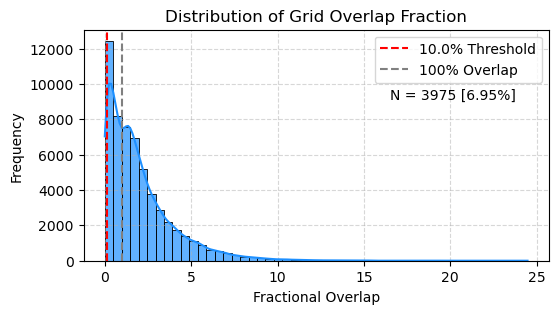

Plot saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/grid_overlap_distribution.png


In [3]:
# Check out the distribution of grid overlap with FRP observations
thresh = 0.10
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < thresh]['grid_index'].count() # less than 5% spatial overlap

# Plot the distribution of the fractional overlap
plt.figure(figsize=(6,3))
sns.histplot(grid['overlap'], kde=True, bins=50, color='dodgerblue', alpha=0.7)

# Add vertical line for the threshold and for 100%
plt.axvline(x=thresh, color='red', linestyle='--', label=f'{thresh*100}% Threshold')
plt.axvline(x=1, color='grey', linestyle='--', label='100% Overlap')

# Customize the plot
plt.title('Distribution of Grid Overlap Fraction')
plt.xlabel('Fractional Overlap')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.text(16.5, plt.ylim()[1] * 0.7, 
         f'N = {n_small} [{round(n_small/len(grid)*100,2)}%]', 
         fontsize=10, color='black')

# Save the plot
out_path = os.path.join(projdir, 'figures/grid_overlap_distribution.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Plot saved to: {out_path}")

In [4]:
# filter out grids below the overlap threshold
print(f"Dropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with <{thresh*100}% fractional overlap.")
grid = grid[grid['overlap'] >= thresh] # remove these observations
print(len(grid))

Dropping [3975 (6.95%)] grids with <10.0% fractional overlap.
53257


In [5]:
# Load the FORTYPCD and the Tree Table summaries

# FORTYPCD
fp = os.path.join(projdir,'data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypnm_gp.csv')
fortyp = pd.read_csv(fp)
print(f"FORTYPCD columns:\n{fortyp.columns}\n")

# Tree Table
fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable.csv')
trees = pd.read_csv(fp)
trees.drop(columns=['Unnamed: 0','forest_pct'], inplace=True)
print(f"Tree Table columns:\n{trees.columns}\n")

# Check on how many grids match
print(f"\tFORTYP unique grids: {len(fortyp['grid_index'].unique())}")
print(f"\t\t total rows: {len(fortyp)}")
print(f"\tTree Table unique grids: {len(trees['grid_index'].unique())}")
print(f"\t\t total rows: {len(trees)}")

FORTYPCD columns:
Index(['Unnamed: 0', 'grid_index', 'fortypnm_gp', 'count', 'total_pixels',
       'pct_cover', 'forest_pixels', 'forest_pct'],
      dtype='object')

Tree Table columns:
Index(['grid_index', 'species_gp_n', 'tmid_n', 'ba_live', 'ba_dead', 'ba_ld',
       'tpp_live', 'tpp_dead', 'tpp_ld', 'qmd_live', 'qmd_dead', 'qmd_ld',
       'tree_ht_live', 'tree_ht_dead', 'balive_total', 'badead_total',
       'ba_ld_total', 'tpp_live_total', 'tpp_dead_total', 'tpp_ld_total',
       'qmd_live_total', 'qmd_dead_total', 'qmd_ld_total', 'ba_live_pr',
       'ba_dead_pr', 'ba_ld_pr', 'tpp_live_pr', 'tpp_dead_pr', 'tpp_ld_pr',
       'qmd_live_pr', 'qmd_dead_pr', 'qmd_ld_pr'],
      dtype='object')

	FORTYP unique grids: 52579
		 total rows: 212133
	Tree Table unique grids: 52575
		 total rows: 312780


In [6]:
# check how many matching grids
match = fortyp[fortyp['grid_index'].isin(trees['grid_index'].unique())]
# Check on how many grids match
print(f"\tFORTYP unique grids: {len(match['grid_index'].unique())}")
print(f"\t\t total rows: {len(match)}")
print(f"\tTree Table unique grids: {len(trees['grid_index'].unique())}")
print(f"\t\t total rows: {len(trees)}")
del match
gc.collect()

	FORTYP unique grids: 52555
		 total rows: 212104
	Tree Table unique grids: 52575
		 total rows: 312780


91

In [7]:
# calculate the dominant forest type using the FORTYPCD
dfortyp = fortyp.loc[fortyp.groupby('grid_index')['pct_cover'].idxmax()]
dfortyp = dfortyp[['grid_index','fortypnm_gp','pct_cover','forest_pixels','forest_pct']]
dfortyp = dfortyp[dfortyp['grid_index'].isin(trees['grid_index'].unique())] # retain matching grids
dfortyp.rename(columns={'pct_cover': 'fortyp_pct'}, inplace=True)
dfortyp.columns

Index(['grid_index', 'fortypnm_gp', 'fortyp_pct', 'forest_pixels',
       'forest_pct'],
      dtype='object')

In [8]:
dfortyp['fortypnm_gp'].unique()

array(['Piñon-juniper', 'Ponderosa', 'Quaking aspen', 'Mixed-conifer',
       'Lodgepole', 'Spruce-fir', 'Rocky mountain juniper',
       'Oak-woodland'], dtype=object)

In [11]:
# Check on how many matches there are between the dominant type and the Tree Table
matches = (dfortyp_sp['grid_index'].isin(trees[trees['species_gp_n'].isin(dfortyp_sp['fortypnm_gp'])]['grid_index'])).sum()
# Print the results
total_grids = dfortyp_sp['grid_index'].nunique()
print(f"\nTotal grids: {total_grids}\n")
print(f"{matches} ({(matches / total_grids) * 100:.2f}%)\n")
del matches, total_grids
gc.collect()


Total grids: 52555

52555 (100.00%)



6906

In [12]:
# merge to the tree table metrics
tree_metrics = dfortyp_sp.merge(trees, on='grid_index', how='left')
tree_metrics.head()

,grid_index,fortypnm_gp,fortyp_pct,forest_pixels,forest_pct,species_gp_n,tmid_n,ba_live,ba_dead,ba_ld,...,qmd_ld_total,ba_live_pr,ba_dead_pr,ba_ld_pr,tpp_live_pr,tpp_dead_pr,tpp_ld_pr,qmd_live_pr,qmd_dead_pr,qmd_ld_pr
0,34602,Piñon-juniper,81.767956,182,99.450549,Gambel oak,4,983.074924,36.591012,1019.665936,...,947.464478,0.030908,0.010298,0.028837,0.187037,0.024794,0.187037,0.074845,0.054830,0.074845
1,34602,Piñon-juniper,81.767956,182,99.450549,Mixed-conifer,1,1757.987391,131.985888,1889.973279,...,947.464478,0.055271,0.037146,0.053450,0.047182,0.004117,0.047182,0.143992,0.511128,0.143992
2,34602,Piñon-juniper,81.767956,182,99.450549,Piñon-juniper,12,25166.851413,3234.725392,28401.576805,...,947.464478,0.791251,0.910387,0.803222,0.711130,0.966973,0.711130,0.205824,0.161750,0.205824
3,34602,Piñon-juniper,81.767956,182,99.450549,Ponderosa,4,3753.173956,149.829507,3903.003463,...,947.464478,0.118001,0.042168,0.110380,0.047573,0.004117,0.047573,0.320515,0.272292,0.320515
4,34602,Piñon-juniper,81.767956,182,99.450549,Quaking aspen,1,40.406737,0.000000,40.406737,...,947.464478,0.001270,0.000000,0.001143,0.002359,0.000000,0.002359,0.119109,0.000000,0.119109


In [13]:
print(len(tree_metrics))

312752


In [14]:
tree_metrics.columns

Index(['grid_index', 'fortypnm_gp', 'fortyp_pct', 'forest_pixels',
       'forest_pct', 'species_gp_n', 'tmid_n', 'ba_live', 'ba_dead', 'ba_ld',
       'tpp_live', 'tpp_dead', 'tpp_ld', 'qmd_live', 'qmd_dead', 'qmd_ld',
       'tree_ht_live', 'tree_ht_dead', 'balive_total', 'badead_total',
       'ba_ld_total', 'tpp_live_total', 'tpp_dead_total', 'tpp_ld_total',
       'qmd_live_total', 'qmd_dead_total', 'qmd_ld_total', 'ba_live_pr',
       'ba_dead_pr', 'ba_ld_pr', 'tpp_live_pr', 'tpp_dead_pr', 'tpp_ld_pr',
       'qmd_live_pr', 'qmd_dead_pr', 'qmd_ld_pr'],
      dtype='object')

In [15]:
tree_metrics[['grid_index','fortypnm_gp','fortyp_pct','species_gp_n',
              'tpp_ld_pr','ba_ld_pr','qmd_ld_pr']].head(12)

,grid_index,fortypnm_gp,fortyp_pct,species_gp_n,tpp_ld_pr,ba_ld_pr,qmd_ld_pr
0,34602,Piñon-juniper,81.767956,Gambel oak,0.187037,0.028837,0.074845
1,34602,Piñon-juniper,81.767956,Mixed-conifer,0.047182,0.053450,0.143992
2,34602,Piñon-juniper,81.767956,Piñon-juniper,0.711130,0.803222,0.205824
3,34602,Piñon-juniper,81.767956,Ponderosa,0.047573,0.110380,0.320515
4,34602,Piñon-juniper,81.767956,Quaking aspen,0.002359,0.001143,0.119109
5,34602,Piñon-juniper,81.767956,Rocky mountain juniper,0.004718,0.002967,0.135715
6,34603,Piñon-juniper,56.886228,Gambel oak,0.328568,0.057084,0.073230
7,34603,Piñon-juniper,56.886228,Mixed-conifer,0.076673,0.108624,0.210269
8,34603,Piñon-juniper,56.886228,Piñon-juniper,0.438366,0.496975,0.172783
9,34603,Piñon-juniper,56.886228,Ponderosa,0.146406,0.326085,0.262644


In [17]:
# Load the climate and topography information

# topography
fp = os.path.join(projdir,'data/earth-engine/exports/gridstats_topo.csv')
topo = pd.read_csv(fp)
print(f"\n{topo.columns}\n")

# climate (gridmet)
fp = os.path.join(projdir,'data/earth-engine/exports/gridstats_gridmet_full.csv')
climate = pd.read_csv(fp)
print(f"\n{climate.columns}\n")


Index(['system:index', 'chili', 'elev', 'grid_index', 'slope', 'tpi', '.geo'], dtype='object')


Index(['system:index', 'Fire_ID', 'erc', 'erc_dv', 'first_obs', 'vpd',
       'vpd_dv', '.geo'],
      dtype='object')



In [18]:
# tidy and merge the climate/topo
climate.rename(columns={'first_obs': 'first_obs_date'}, inplace=True) # for joining to the grid data
climate = climate[['Fire_ID', 'first_obs_date', 'erc', 'erc_dv', 'vpd', 'vpd_dv']] # keep needed columns
climate['Fire_ID'] = climate['Fire_ID'].astype(str) # to match the grid column
grid['first_obs_date'] = grid['first_obs_date'].astype(str) # to match gee output
# merge climate to the grid by fire id and first acquisition day
grid_clim = grid.merge(climate, on=['Fire_ID','first_obs_date'], how='left')
print(f"\n{grid_clim.columns}\n")


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'x', 'y', 'erc', 'erc_dv', 'vpd', 'vpd_dv'],
      dtype='object')



In [19]:
# merge the topography to the grid
topo = topo[['grid_index', 'elev', 'slope', 'chili', 'tpi']]
grid_clim_topo = grid_clim.merge(topo, on='grid_index', how='left')
grid_clim_topo.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'x', 'y', 'erc', 'erc_dv', 'vpd', 'vpd_dv', 'elev', 'slope', 'chili',
       'tpi'],
      dtype='object')

In [20]:
tree_metrics.columns

Index(['grid_index', 'fortypnm_gp', 'fortyp_pct', 'forest_pixels',
       'forest_pct', 'species_gp_n', 'tmid_n', 'ba_live', 'ba_dead', 'ba_ld',
       'tpp_live', 'tpp_dead', 'tpp_ld', 'qmd_live', 'qmd_dead', 'qmd_ld',
       'tree_ht_live', 'tree_ht_dead', 'balive_total', 'badead_total',
       'ba_ld_total', 'tpp_live_total', 'tpp_dead_total', 'tpp_ld_total',
       'qmd_live_total', 'qmd_dead_total', 'qmd_ld_total', 'ba_live_pr',
       'ba_dead_pr', 'ba_ld_pr', 'tpp_live_pr', 'tpp_dead_pr', 'tpp_ld_pr',
       'qmd_live_pr', 'qmd_dead_pr', 'qmd_ld_pr'],
      dtype='object')

In [22]:
# merge the FRP, climate, and topogrpahy to the forest metrics table
grid_tm = tree_metrics.merge(grid_clim_topo, on=['grid_index'], how='inner')
print(grid_tm.head(3))

   grid_index    fortypnm_gp  fortyp_pct  forest_pixels  forest_pct  \
0       34602  Piñon-juniper   81.767956            182   99.450549   
1       34602  Piñon-juniper   81.767956            182   99.450549   
2       34602  Piñon-juniper   81.767956            182   99.450549   

    species_gp_n  tmid_n       ba_live      ba_dead         ba_ld  ...  \
0     Gambel oak       4    983.074924    36.591012   1019.665936  ...   
1  Mixed-conifer       1   1757.987391   131.985888   1889.973279  ...   
2  Piñon-juniper      12  25166.851413  3234.725392  28401.576805  ...   

           x          y        erc     erc_dv       vpd    vpd_dv  \
0 -109.55098  37.761913  67.272727  14.479287  1.125455  0.352753   
1 -109.55098  37.761913  67.272727  14.479287  1.125455  0.352753   
2 -109.55098  37.761913  67.272727  14.479287  1.125455  0.352753   

          elev     slope       chili        tpi  
0  2330.355876  8.706296  204.949908  22.736575  
1  2330.355876  8.706296  204.949908  22.

In [23]:
len(grid_tm)

319734

In [24]:
# save this file out.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_fortypnm_gp_tm_ct.csv')
grid_tm.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_fortypnm_gp_tm_ct.csv
